# Bitstamp Assesment Test
## Task 1: Where are my assets?

Welcome to crypto! The Product team is seeking insights into the performance of our lending product. Your mission is to:

1. Clean (if needed) and enrich the attached data (*task_1_earn.csv*) – end goal is having clean table which can be
easily used (without any manipulation) for any kind of analytics. The presented data includes all completed lending
withdrawals (when a user makes a request to stop lending). Add yearweek and yearmonth columns and any other
that will be useful to end users.
Definitions:
    - **User_Id** is the id of user
    - **Id** is the identifier of the withdrawal request
    - **Requested_at** means when the user made a request to unlend
    - **Finished_at** means when the lending provider completed the lending and user got the funds

2. Prepare an analysis of the lending product with the data you have so the product team will be able to identify if we
have any issues with our lending provider. Include numbers and graphs and don't forget to write key findings.
    -  Identify key trends, patterns, and potential issues with the lending provider.

3. Based on your analysis:
    - **Identify opportunities** to improve the **performance** and **reliability** of our lending provider.
    - Suggest actionable **recommendations** for the Product team to address these issues.

### Import libraries
Import main libraries for analysing data and visualisation

In [268]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
from IPython.display import display

sns.set_theme(style="whitegrid")


### Load Data

Import data from the *task_1_earn.csv* file. The tester shoul change the **file_path_1** variable to the path to the file, if it is not already in the same directory.

In [269]:
# Load the CSV file into a DataFrame /w check for file existence
file_path_1 = '../Data/task_1_earn.csv'  # Path to the CSV file (change if the testers file is in a different directory)
try:
    df = pd.read_csv(file_path_1)
    print("Data loaded successfully!")
except FileNotFoundError:
    print(f"File not found at {file_path_1}. Please check the path.")

# Display the first few rows of the DataFrame
df.head()


Data loaded successfully!


,currency,user_id,id,amount_native,amount_usd,requested_at,finished_at
0,BTC,44017161,117200,17.449950,1234.825630,2020-11-24 22:59:35,2020-01-25 14:00:02
1,MATIC,46740482,117197,17.450786,546.674743,2020-01-24 22:33:10,2020-01-25 02:00:20
2,PEPE,46489105,117194,17.446612,556.810541,2020-01-24 22:12:18,2020-01-25 02:00:19
3,PEPE,46117080,117193,17.446693,1045.785866,2020-01-24 22:03:20,2020-01-25 02:00:19
4,AVAX,47626266,117191,17.454170,653.661058,2020-01-24 22:01:30,2020-01-25 02:00:41


### Cleaning the data

Upon inspection we can see that some of the **requested_at** or **finished_at** inputs have invalid values (e. g. requested_at date being February $30^{\text{th}}$). 

We prepare functions that check if the date is valid (*is_valid_date()*) and then correct the date (*fix_invalid_date()*). The date is corrected to the last valid date before it for values of **requested_at** (e. g. 2020-4-31 is changed to 2020-04-30), and it is corrected to the first valid date after it for values of **finished_at**. All the changes to dates are logged into the data_correction_log.txt file.


In [270]:
# Function to adjust invalid dates
def fix_invalid_date(date_str, adjust='previous'):
    # Split the date and time parts
    date_part, time_part = date_str.split(' ')
    year, month, day = map(int, date_part.split('-'))
    time_str = time_part

    # Adjust the data backwards for requested_at -> parameter 'previous'
    if adjust == 'previous':
        # Move backward until a valid date is found (e.g. 2020-02-31 -> 2020-02-30 -> 2020-02-29)
        while True:
            try:
                new_date = datetime(year, month, day)
                break
            except ValueError:
                day -= 1

    # Adjust the data forward for finished_at -> parameter 'next'
    elif adjust == 'next':
        while True:
            try:
                new_date = datetime(year, month, day)
                break
            except ValueError:
                # Set the date to the first day of the next month
                month += 1
                day = 1

    # Return the fixed date with the original time
    return new_date.strftime('%Y-%m-%d') + ' ' + time_str

# -----------------------------------------------------------------------------------------

# Helper function to parse date flexibly
def is_valid_date(date_str):
    try:
        # Try parsing with fractional seconds
        datetime.strptime(date_str, '%Y-%m-%d %H:%M:%S.%f')
        return True
    except ValueError:
        try:
            # Try parsing without fractional seconds
            datetime.strptime(date_str, '%Y-%m-%d %H:%M:%S')
            return True
        except ValueError:
            return False

# =========================================================================================

# Initialize a log list to capture changes
log_entries = []

# -----------------------------------------------------------------------------------------

# Process 'requested_at' and 'finished_at' columns
for idx, row in df.iterrows():
    # Process 'requested_at'
    original_requested_at = row['requested_at']
    if isinstance(original_requested_at, str):
        if not is_valid_date(original_requested_at):
            new_requested_at = fix_invalid_date(original_requested_at, adjust='previous')
            df.at[idx, 'requested_at'] = new_requested_at
            log_entries.append(
                f"Invalid requested_at value for input id: {row['id']}. "
                f"Value changed from {original_requested_at} to {new_requested_at}"
            )

    # Process 'finished_at'
    original_finished_at = row['finished_at']
    if isinstance(original_finished_at, str):
        if not is_valid_date(original_finished_at):
            new_finished_at = fix_invalid_date(original_finished_at, adjust='next')
            df.at[idx, 'finished_at'] = new_finished_at
            log_entries.append(
                f"Invalid finished_at value for input id: {row['id']}. "
                f"Value changed from {original_finished_at} to {new_finished_at}"
            )

# -----------------------------------------------------------------------------------------

# Save the log entries to a file
with open('Outputs/date_correction_log.txt', 'w') as log_file:
    for entry in log_entries:
        log_file.write(entry + '\n')

print("Invalid dates fixed. Changes logged to 'date_correction_log.txt'.")


Invalid dates fixed. Changes logged to 'date_correction_log.txt'.


Before continuing we convert all time values into datetime and check that there are no NaT values.
We then add a couple of new columns that the users could find useful. We add:
- **yearweek**: A text column consisting of year and week of the request (e. g. 2020-47)
- **yearmonth**: A text column consisting of year and month of the request (e. g. 2020-02)
- **time_to_complete**: Gives us the difference between the time of the requested withdrawal and the time when the request for withdrawal was completed. It is given in hours.
- **possible_error**: A boolean value marking instances of **time_to_complete** that are negative, meaning the request was fulfilled before it was requestet. These are likely errors in marking the time.
- **conversion_rate**: The conversion rate from the native currency to USD at the time the withdrawal happens.

In [271]:
# Convert 'requested_at' and 'finished_at' columns to datetime after all fixes
df['requested_at'] = pd.to_datetime(df['requested_at'], errors='coerce')
df['finished_at'] = pd.to_datetime(df['finished_at'], errors='coerce')

# Ensure there are no NaT values after conversion (log and handle if necessary)
if df['requested_at'].isnull().any() or df['finished_at'].isnull().any():
    print("Warning: Some dates could not be converted to datetime.")

# Add yearweek and yearmonth columns
df['yearweek'] = df['requested_at'].dt.strftime('%Y-%U')
df['yearmonth'] = df['requested_at'].dt.strftime('%Y-%m')

# Add a column for the day of the week when the withdrawal was requested
df['requested_day_of_week'] = df['requested_at'].dt.day_name()

# Add time_to_complete column (in hours)
df['time_to_complete'] = (df['finished_at'] - df['requested_at']).dt.total_seconds() / 3600

# Add possible_error column (where time_to_complete is negative)
df['possible_error'] = df['time_to_complete'] < 0

# Add conversion_rate column (amount_usd / amount_native)
df['conversion_rate'] = df['amount_usd'] / df['amount_native']

# Display the first few rows to verify
print(df.head())


  currency   user_id      id  amount_native   amount_usd        requested_at  \
0      BTC  44017161  117200      17.449950  1234.825630 2020-11-24 22:59:35   
1    MATIC  46740482  117197      17.450786   546.674743 2020-01-24 22:33:10   
2     PEPE  46489105  117194      17.446612   556.810541 2020-01-24 22:12:18   
3     PEPE  46117080  117193      17.446693  1045.785866 2020-01-24 22:03:20   
4     AVAX  47626266  117191      17.454170   653.661058 2020-01-24 22:01:30   

          finished_at yearweek yearmonth requested_day_of_week  \
0 2020-01-25 14:00:02  2020-47   2020-11               Tuesday   
1 2020-01-25 02:00:20  2020-03   2020-01                Friday   
2 2020-01-25 02:00:19  2020-03   2020-01                Friday   
3 2020-01-25 02:00:19  2020-03   2020-01                Friday   
4 2020-01-25 02:00:41  2020-03   2020-01                Friday   

   time_to_complete  possible_error  conversion_rate  
0      -7304.992500            True        70.763847  
1          3

In [272]:
# Check for missing values
missing_values = df.isnull().sum()

# Check for duplicate rows
duplicates = df.duplicated().sum()

# Check the data types of key columns
data_types = df.dtypes

# Output the results
print("Missing Values:\n", missing_values)
print("\nNumber of Duplicate Rows:", duplicates)
print("\nData Types:\n", data_types)

# Identify any negative time_to_complete values
possible_error_rows = df[df['possible_error'] == True]
print(len(possible_error_rows), "rows have negative time_to_complete values.")

# Save the rows with possible errors to a CSV file
possible_error_rows.to_csv('Outputs/possible_error_rows.csv', index=False)





Missing Values:
 currency                 0
user_id                  0
id                       0
amount_native            0
amount_usd               0
requested_at             0
finished_at              0
yearweek                 0
yearmonth                0
requested_day_of_week    0
time_to_complete         0
possible_error           0
conversion_rate          0
dtype: int64

Number of Duplicate Rows: 0

Data Types:
 currency                         object
user_id                           int64
id                                int64
amount_native                   float64
amount_usd                      float64
requested_at             datetime64[ns]
finished_at              datetime64[ns]
yearweek                         object
yearmonth                        object
requested_day_of_week            object
time_to_complete                float64
possible_error                     bool
conversion_rate                 float64
dtype: object
427 rows have negative time_to_complete va

Looking at our cleaned data we can see there are no missing values and no duplicate rows. The data types seem in order. 

The only possible issue could be the 427 rows that have negative time to complete values. There does not seem to be a simple way to automatically solve those issues and likely has to be done manually, looking at each specific transaction. For that we have created a separate file with all detected errors.

There look to be bundles of this issue at the end of some months, however there are some complete outliers like the transaction with *id*=117200, where we have 2020-11... where it should most likely be 2020-01...

Most of these errors could be fixed by looking at each separate clump and fixing every wrong data point in it in a similar way. However, since there are only 427 instances of errors in 27,674 datapoints or roughly 1.5% we can just use the data as is and discard the negative **time_to_complete** values when doing the analysis.


### Export Cleaned Data
We now export the cleaned and enriched data to a new .csv for easier manual review before we begin with data analysis.

In [273]:
# Save the cleaned data to a new CSV file
df.to_csv('Outputs/task_1_earn_cleaned.csv', index=False)

### Data Analysis

Let's first look at the data **manually** to see if there are things that stand out. 

We see that there is enormous volatility in conversions between the given cryptocurrency and USD. Withdrawal requests with similar native values that were recorded minutes apart for the same currency have vastly different USD values. We will have to analyse if there are other factors that contribute to this volatility or if it is only the price volatility of cryptocurrencies.

Another feature of the data is that the majority of values for amount_native range from 17.4 to 17.6. We will have to perform analysis to get a specific distribution. This could indicate there is a lower limit for the amount able to be withdrawn set at ~17 units of the currency.

Looking at the processing time, we can see that there is also a lot of volatility there. By the first look one factor determining the length of time to fulfil the request is the currency (e. g. When withdrawing PEPE the time_to_complete is around 150 hours, while it is between 2 and 20 hours for Bitcoin withdrawals)

Taking a quick look at the user_id data shows us we have a few different types of users. There are some repeating users with frequent transactions, sometimes spanning in just one currency, sometimes spanning through multiple. There are also some users with infrequent transactions. 

Lastly, we can notice that a lot of withdrawals where the amount_native is higher than average, the conversion rate is also much better. This indicates that the bigger clients take their assets out of the lending program when the opportunity to realise gains arises. 

Now lets analyse the data to see if we can confirm our preliminary findings or find some other paterns.



#### Conversion rate analysis

In [274]:
# Calculate and print mean, median, max, min and standard deviation of conversion_rate for each currency
conversion_rate_stats = df.groupby('currency')['conversion_rate'].agg(['mean', 'median', 'max', 'min', 'std'])
print(conversion_rate_stats)

# Calculate average volatility of conversion_rate for the entire market
average_volatility = df.groupby('currency')['conversion_rate'].std().mean()
print("\nAverage Volatility of Conversion Rate:", average_volatility)


                mean     median           max        min          std
currency                                                             
AVAX       75.363026  36.117003   7905.168565  30.722303   227.560547
BTC       133.718774  39.699977  20303.898006  30.722303   705.393362
DOT        33.791395  31.622448    102.302339  30.722303     5.863523
EUROC      36.288342  32.695380     67.061392  30.722316     7.458707
MATIC      41.891382  31.289264    987.924893  24.225099    50.086403
PEPE      236.838083  47.383943  25045.689508  30.722309  1021.089761
SHIB       36.208423  31.933581     62.048205  30.722303     7.971299
SUSHI      48.215671  33.079197   1418.468204  30.722303    69.894383
UNI        33.563956  31.198826     93.517455  25.726194     6.645004
USDC       52.564546  34.009854    950.133606  30.722303    71.166755
USDT       25.187652  27.611359     30.722303   6.184830     6.101072
WECAN      48.086014  32.580181   3093.273895  30.722303   109.117860
XRP        36.680752

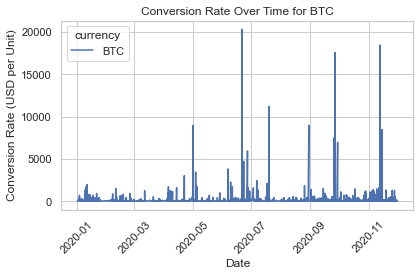

<Figure size 432x288 with 0 Axes>

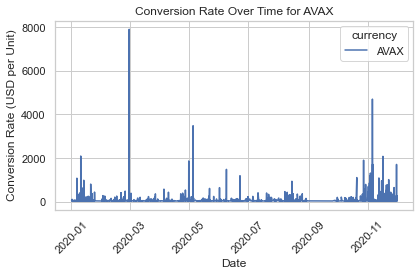

<Figure size 432x288 with 0 Axes>

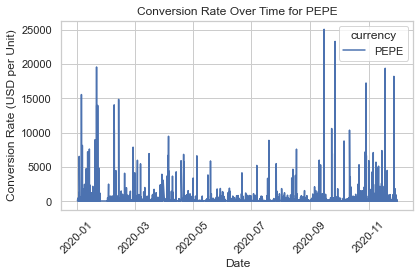

<Figure size 432x288 with 0 Axes>

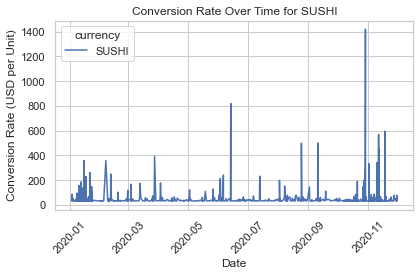

<Figure size 432x288 with 0 Axes>

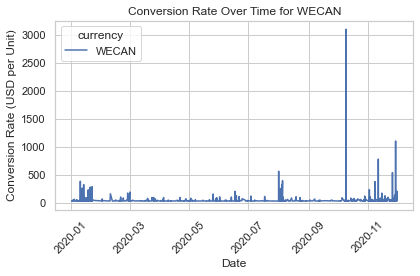

<Figure size 432x288 with 0 Axes>

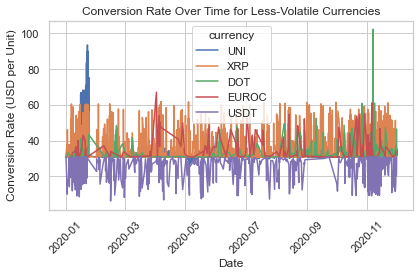

<Figure size 432x288 with 0 Axes>

In [275]:

# Make a few sepateat graphs that shows conversion rate over time for selected currencies
# We make separate graphs for currencies with high volatility (BTC, AVAX, PEPE)

# Define the currencies with high volatility and their respective colors
currencies = ['BTC', 'AVAX', 'PEPE', 'SUSHI', 'WECAN']

# Loop through each currency to create the line plots
for currency in currencies:
    # Filter data for the specific currency
    currency_data = df[df['currency'] == currency]
    
    # Create a line plot for conversion rate over time
    plt.figure(figsize=(6, 4))
    sns.lineplot(data=currency_data, x='requested_at', y='conversion_rate', hue='currency', ci=None)
    
    # Set the titles and labels
    plt.title(f'Conversion Rate Over Time for {currency}')
    plt.xlabel('Date')
    plt.ylabel('Conversion Rate (USD per Unit)')
    plt.xticks(rotation=45)
    
    # Adjust layout and show plot
    plt.tight_layout()
    plt.show()

    # Save plot to a file
    plt.savefig(f'Outputs/Plots/conversion_rate_{currency}.png')
    

# Create a line plot for the conversion rate over time for some of the non-volatile currencies
non_volatile = ['DOT', 'EUROC', 'USDT', 'XRP', 'UNI']

# Filter the data for the non-volatile currencies
df_non_volatile = df[df['currency'].isin(non_volatile)]

# Create a line plot for the conversion rate over time for the less-volatile currencies
plt.figure(figsize=(6, 4))
sns.lineplot(data=df_non_volatile, x='requested_at', y='conversion_rate', hue='currency', ci=None)
plt.title('Conversion Rate Over Time for Less-Volatile Currencies')
plt.xlabel('Date')
plt.ylabel('Conversion Rate (USD per Unit)')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# Save plot to a file
plt.savefig('Outputs/Plots/conversion_rate_non_volatile.png')






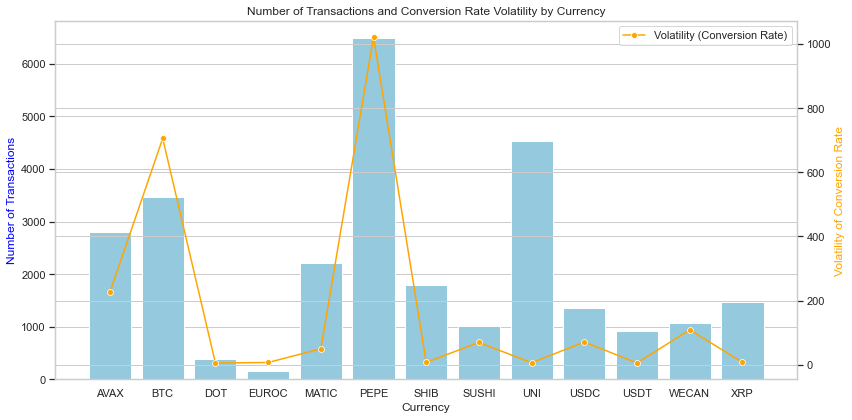

<Figure size 432x288 with 0 Axes>

In [276]:
# Make graphs that shows the conversion rate volatility for each currency and the number of transactions for each currency

# Group by currency and calculate the number of transactions and the standard deviation of conversion rate (volatility)
currency_stats = df.groupby('currency').agg(
    num_transactions=('id', 'count'),
    conversion_rate_volatility=('conversion_rate', 'std')
).reset_index()

# Create a bar plot for number of transactions and a line plot for conversion rate volatility
fig, ax1 = plt.subplots(figsize=(12, 6))

# Bar plot for the number of transactions
sns.barplot(x='currency', y='num_transactions', data=currency_stats, ax=ax1, color='skyblue', label='Number of Transactions')

# Line plot for conversion rate volatility (on a secondary y-axis)
ax2 = ax1.twinx()
sns.lineplot(x='currency', y='conversion_rate_volatility', data=currency_stats, ax=ax2, color='orange', marker='o', label='Volatility (Conversion Rate)')

# Set titles and labels
ax1.set_xlabel('Currency')
ax1.set_ylabel('Number of Transactions', color='blue')
ax2.set_ylabel('Volatility of Conversion Rate', color='orange')
ax1.set_title('Number of Transactions and Conversion Rate Volatility by Currency')

# Rotate the x-axis labels for better readability
plt.xticks(rotation=45)

# Show the plot
plt.tight_layout()
plt.show()

# Save plot to a file
plt.savefig('Outputs/Plots/transactions_and_volatility.png')




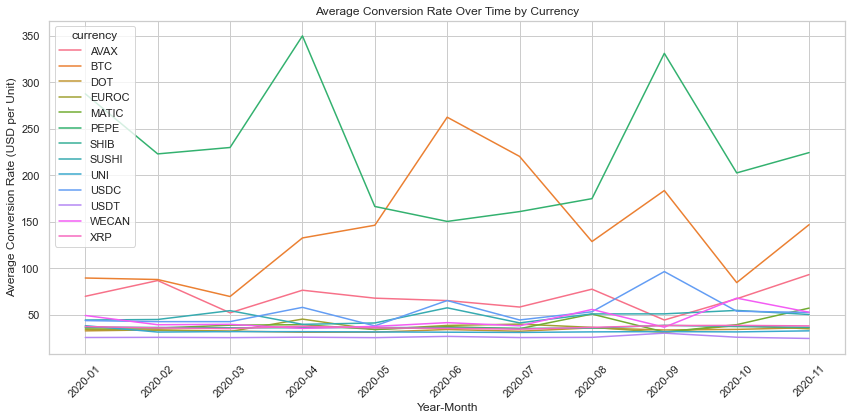

<Figure size 432x288 with 0 Axes>

In [277]:
# Make a graph showing all currency conversion rates over time (using yeramonth as x-axis) showing the range of values like you did in the first graph generated (that is now deleted)
# Calculate the average conversion rate for each currency and yearmonth
average_conversion_rate = df.groupby(['currency', 'yearmonth'])['conversion_rate'].mean().reset_index()

# Create a line plot for the average conversion rate over time for each currency
plt.figure(figsize=(12, 6))
sns.lineplot(data=average_conversion_rate, x='yearmonth', y='conversion_rate', hue='currency', ci=None)

# Set the titles and labels
plt.title('Average Conversion Rate Over Time by Currency')
plt.xlabel('Year-Month')
plt.ylabel('Average Conversion Rate (USD per Unit)')
plt.xticks(rotation=45)

# Adjust layout and show plot
plt.tight_layout()
plt.show()

# Save plot to a file
plt.savefig('Outputs/Plots/average_conversion_rate_over_time.png')



#### Withdrawal size analysis

In [278]:
# Calculate mean, median, max, min and standard deviation of amount_native for each currency
amount_native_stats = df.groupby('currency')['amount_native'].agg(['mean', 'median', 'max', 'min', 'std'])
print(amount_native_stats)


               mean     median          max        min         std
currency                                                          
AVAX      17.548854  17.455971    59.094104  17.446609    0.985178
BTC       17.456205  17.447435    19.947657  17.446609    0.070134
DOT       18.630410  17.759623    56.776225  17.446609    3.108306
EUROC     28.660051  18.448219  1014.271241  17.446615   77.588146
MATIC     19.694763  17.543889   337.344826  17.446609   12.529125
PEPE      17.447504  17.446677    17.613052  17.446609    0.004895
SHIB      36.734749  18.145424  5625.033306  17.446609  155.523403
SUSHI     17.512430  17.455307    24.162600  17.446609    0.297841
UNI       34.938308  19.113843  3349.741827  17.446609   92.522807
USDC      18.198147  17.512615   117.992307  17.446609    4.821705
USDT      55.656224  20.258742  6709.621087  17.446609  324.445546
WECAN     17.459960  17.447947    21.740896  17.446609    0.134997
XRP       37.268231  18.495847  4347.509957  17.446609  137.41

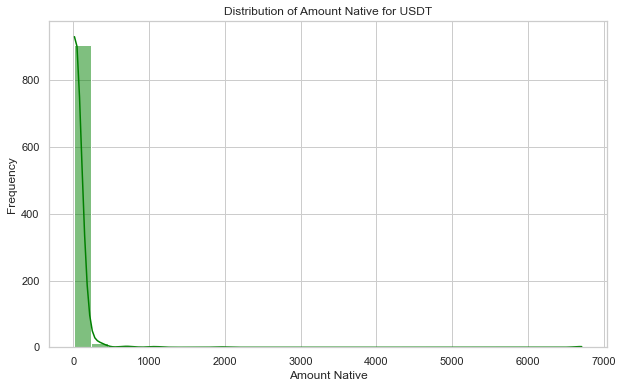

<Figure size 432x288 with 0 Axes>

In [279]:

# Filter the data for USDT currency
df_usdt = df[df['currency'] == 'USDT']

# Create a distribution plot for 'amount_native' for USDT
plt.figure(figsize=(10, 6))
sns.histplot(df_shib['amount_native'], kde=True, color='green', bins=30)
plt.title('Distribution of Amount Native for USDT')
plt.xlabel('Amount Native')
plt.ylabel('Frequency')
plt.show()

# Save plot to a file
plt.savefig('Outputs/Plots/amount_native_distribution_usdt.png')


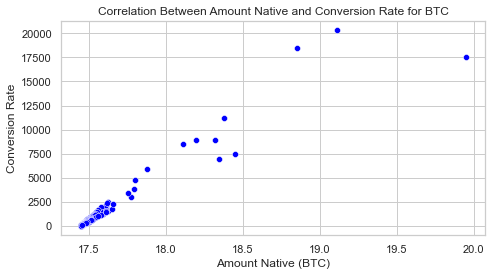


Overall Correlation Between Amount Native and Conversion Rate for BTC:
                  amount_native  conversion_rate
amount_native         1.000000         0.965816
conversion_rate       0.965816         1.000000


<Figure size 432x288 with 0 Axes>

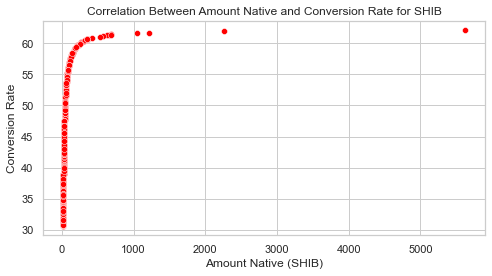


Overall Correlation Between Amount Native and Conversion Rate for SHIB:
                  amount_native  conversion_rate
amount_native         1.000000         0.326819
conversion_rate       0.326819         1.000000


<Figure size 432x288 with 0 Axes>

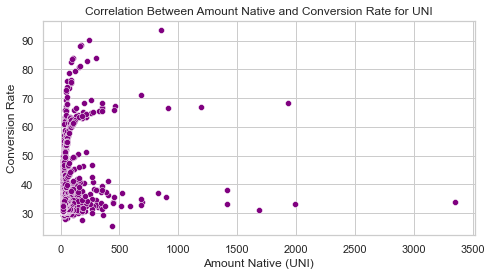


Overall Correlation Between Amount Native and Conversion Rate for UNI:
                  amount_native  conversion_rate
amount_native         1.000000         0.246473
conversion_rate       0.246473         1.000000


<Figure size 432x288 with 0 Axes>

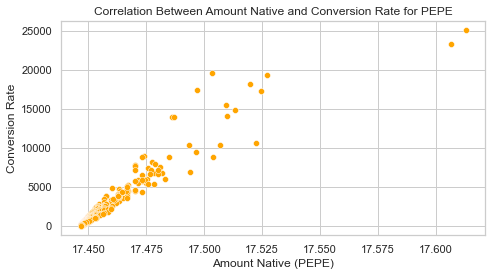


Overall Correlation Between Amount Native and Conversion Rate for PEPE:
                  amount_native  conversion_rate
amount_native         1.000000         0.959248
conversion_rate       0.959248         1.000000


<Figure size 432x288 with 0 Axes>

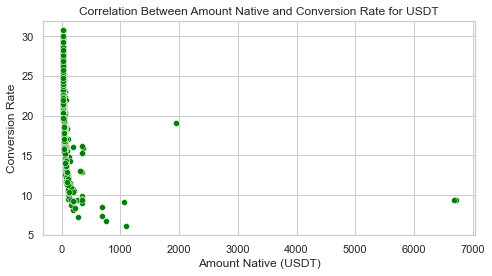


Overall Correlation Between Amount Native and Conversion Rate for USDT:
                  amount_native  conversion_rate
amount_native         1.000000        -0.252331
conversion_rate      -0.252331         1.000000


<Figure size 432x288 with 0 Axes>

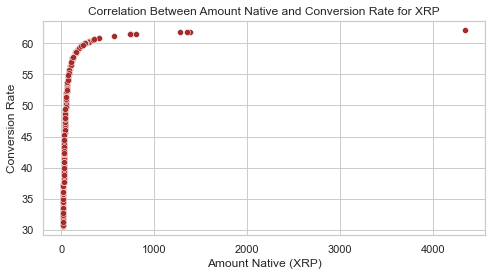


Overall Correlation Between Amount Native and Conversion Rate for XRP:
                  amount_native  conversion_rate
amount_native         1.000000         0.358372
conversion_rate       0.358372         1.000000


<Figure size 432x288 with 0 Axes>

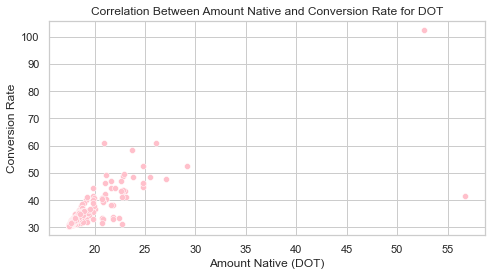


Overall Correlation Between Amount Native and Conversion Rate for DOT:
                  amount_native  conversion_rate
amount_native          1.00000          0.75142
conversion_rate        0.75142          1.00000


<Figure size 432x288 with 0 Axes>

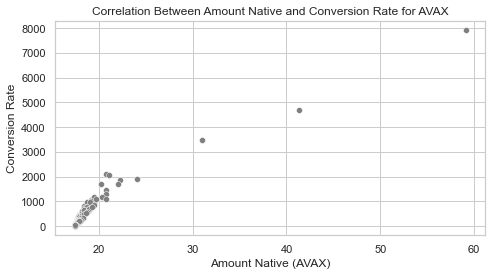


Overall Correlation Between Amount Native and Conversion Rate for AVAX:
                  amount_native  conversion_rate
amount_native         1.000000         0.937414
conversion_rate       0.937414         1.000000


<Figure size 432x288 with 0 Axes>

In [280]:

# Define the currencies and their respective colors
currencies = ['BTC', 'SHIB', 'UNI', 'PEPE', 'USDT', 'XRP', 'DOT', 'AVAX']
colors = ['blue', 'red', 'purple', 'orange', 'green', 'brown', 'pink', 'gray']

# Loop through each currency to create scatter plots and print correlation table
for currency, color in zip(currencies, colors):
    # Filter data for the specific currency
    currency_data = df[df['currency'] == currency]
    
    # Create a scatter plot for each currency
    plt.figure(figsize=(7, 4))
    sns.scatterplot(x='amount_native', y='conversion_rate', data=currency_data, color=color)

    # Set the titles and labels
    plt.title(f'Correlation Between Amount Native and Conversion Rate for {currency}')
    plt.xlabel(f'Amount Native ({currency})')
    plt.ylabel('Conversion Rate')

    # Show the plot
    plt.tight_layout()
    plt.show()

    # Calculate the correlation for the specific currency
    correlation = currency_data[['amount_native', 'conversion_rate']].corr()
    print(f"\nOverall Correlation Between Amount Native and Conversion Rate for {currency}:\n", correlation)

    # Save plot to a file
    plt.savefig(f'Outputs/Plots/correlation_{currency}.png')

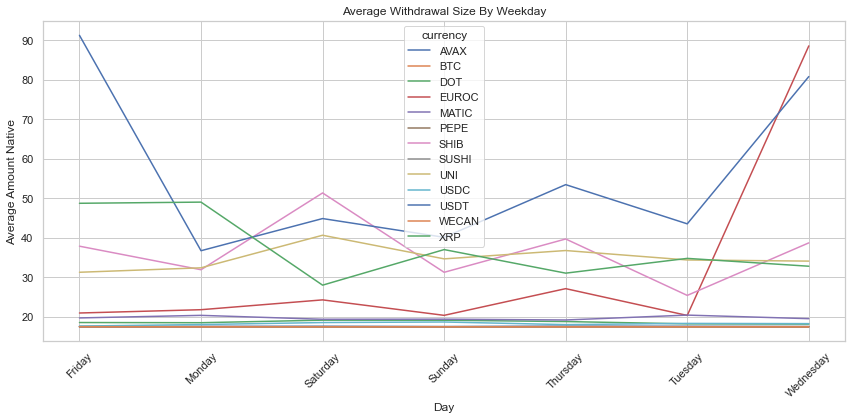

In [281]:
df['yearmonth'] = df['requested_at'].dt.to_period('M')
monthly_trends = df.groupby(['requested_day_of_week', 'currency'])['amount_native'].mean().unstack()

monthly_trends.plot(figsize=(12, 6))
plt.title('Average Withdrawal Size By Weekday')
plt.xlabel('Day')
plt.ylabel('Average Amount Native')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


#### Processing time analysis

In [282]:
# Make a new table with negative time_to_complete values removed
df_processing_times = df[df['possible_error'] == False]

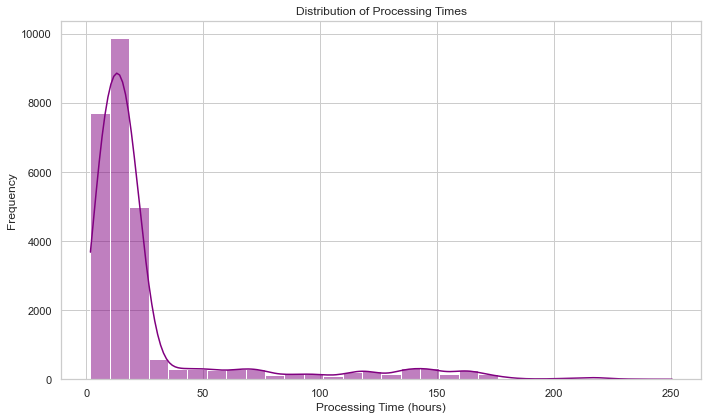

<Figure size 432x288 with 0 Axes>

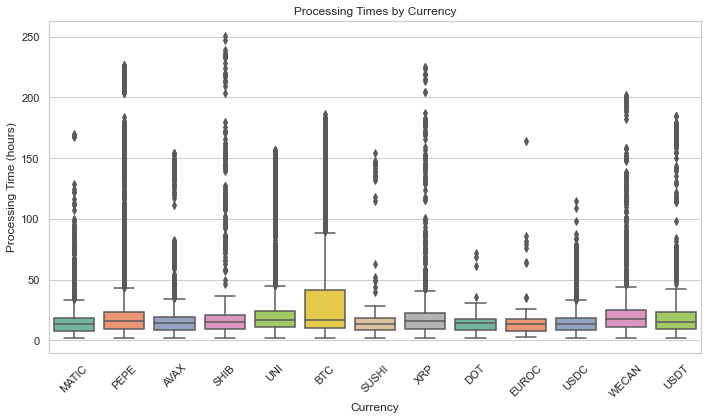

               mean     median         max       min        std
currency                                                       
AVAX      18.944534  14.411111  154.156667  2.003056  22.946886
BTC       40.674558  16.484722  186.069722  2.017778  51.499339
DOT       14.095906  14.085000   71.505556  2.257222   7.591237
EUROC     16.055362  13.144861  163.800556  2.937500  17.689264
MATIC     16.807633  13.609722  170.245556  1.999444  16.950943
PEPE      31.318628  15.645972  226.845278  1.857778  44.963721
SHIB      23.079697  15.143472  250.639167  2.115556  34.317048
SUSHI     16.108818  13.678889  154.023056  2.009444  18.951096
UNI       32.292256  16.937917  156.984444  1.999167  38.774276
USDC      16.577930  13.685278  114.748056  2.009167  14.430348
USDT      27.569154  15.001389  184.971111  2.018889  38.674835
WECAN     32.454712  17.852917  201.769167  1.991667  40.484676
XRP       25.344675  16.043611  224.999444  2.022222  35.528285
394 transactions were completed in less 

<Figure size 432x288 with 0 Axes>

In [283]:
# Histogram of processing times
plt.figure(figsize=(10, 6))
sns.histplot(df_processing_times['time_to_complete'], kde=True, color='purple', bins=30)
plt.title('Distribution of Processing Times')
plt.xlabel('Processing Time (hours)')
plt.ylabel('Frequency')
plt.tight_layout()
plt.show()

# Save plot to a file
plt.savefig('Outputs/Plots/processing_times_distribution.png')

# Boxplot for processing times
plt.figure(figsize=(10, 6))
sns.boxplot(x='currency', y='time_to_complete', data=df_processing_times, palette='Set2')
plt.title('Processing Times by Currency')
plt.xlabel('Currency')
plt.ylabel('Processing Time (hours)')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# Print a table showing the mean, median, max, min and standard deviation of processing times for each currency
processing_time_stats = df_processing_times.groupby('currency')['time_to_complete'].agg(['mean', 'median', 'max', 'min', 'std'])
print(processing_time_stats)

# Save plot to a file
plt.savefig('Outputs/Plots/processing_times.png')

# How many transactions were completed in less than 3 hours?
transactions_3h = df_processing_times[df_processing_times['time_to_complete'] < 3]
print(len(transactions_3h), "transactions were completed in less than 1 hour.")

# How many transactions took less than 24 hours to complete?
transactions_24h = df_processing_times[df_processing_times['time_to_complete'] < 24]
print(len(transactions_24h), "transactions were completed in less than 24 hours.")

# How many transactions took less than 24 hours to complete?
transactions_48h = df_processing_times[df_processing_times['time_to_complete'] < 48]
print(len(transactions_48h), "transactions were completed in less than 48 hours.")

# How many transactions took more than 48 hours to complete?
transactions_48plus = df_processing_times[df_processing_times['time_to_complete'] > 48]
print(len(transactions_48plus), "transactions were completed in more than 24 hours.")



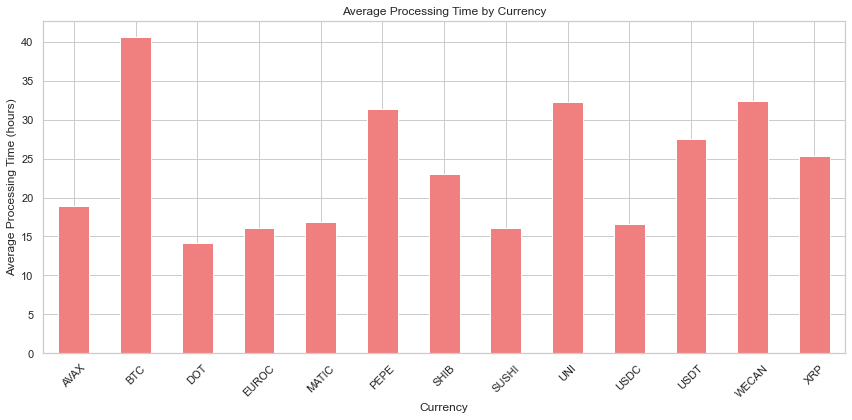

<Figure size 432x288 with 0 Axes>

In [284]:
# Group by currency and calculate average processing time
currency_processing_time = df_processing_times.groupby('currency')['time_to_complete'].mean()

# Create a bar plot for processing times by currency
plt.figure(figsize=(12, 6))
currency_processing_time.plot(kind='bar', color='lightcoral')
plt.title('Average Processing Time by Currency')
plt.xlabel('Currency')
plt.ylabel('Average Processing Time (hours)')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# Save plot to a file
plt.savefig('Outputs/Plots/average_processing_time.png')


Correlation Between Withdrawal Amount and Processing Time:
                   amount_native  time_to_complete
amount_native          1.000000          0.045768
time_to_complete       0.045768          1.000000


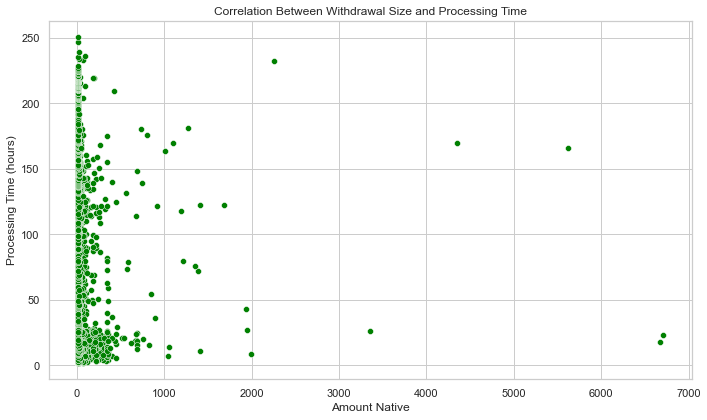

Correlation Between Withdrawal Amount (USD) and Processing Time:
                   amount_usd  time_to_complete
amount_usd          1.000000          0.086383
time_to_complete    0.086383          1.000000


<Figure size 432x288 with 0 Axes>

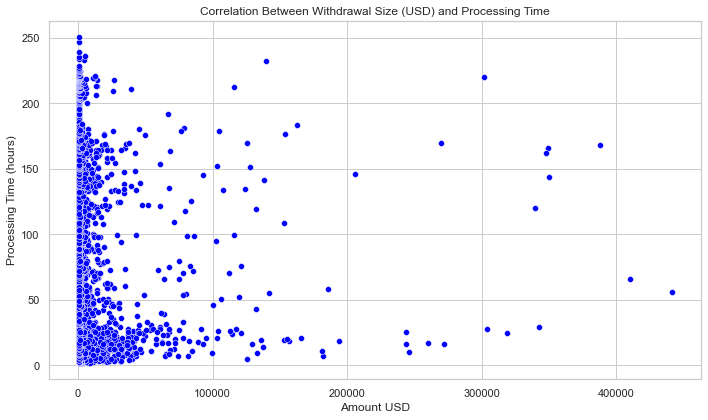

<Figure size 432x288 with 0 Axes>

In [285]:
# Calculate the correlation between amount_native and time_to_complete
correlation_processing = df_processing_times[['amount_native', 'time_to_complete']].corr()
print("Correlation Between Withdrawal Amount and Processing Time:\n", correlation_processing)

# Scatter plot to visualize the correlation
plt.figure(figsize=(10, 6))
sns.scatterplot(x='amount_native', y='time_to_complete', data=df_processing_times, color='green')
plt.title('Correlation Between Withdrawal Size and Processing Time')
plt.xlabel('Amount Native')
plt.ylabel('Processing Time (hours)')
plt.tight_layout()
plt.show()

# Save plot to a file
plt.savefig('Outputs/Plots/processing_time_vs_amount_native.png')

# Calculate the correlation between amount_usd and time_to_complete
correlation_processing_usd = df_processing_times[['amount_usd', 'time_to_complete']].corr()
print("Correlation Between Withdrawal Amount (USD) and Processing Time:\n", correlation_processing_usd)

# Scatter plot to visualize the correlation
plt.figure(figsize=(10, 6))
sns.scatterplot(x='amount_usd', y='time_to_complete', data=df_processing_times, color='blue')
plt.title('Correlation Between Withdrawal Size (USD) and Processing Time')
plt.xlabel('Amount USD')
plt.ylabel('Processing Time (hours)')
plt.tight_layout()
plt.show()

# Save plot to a file
plt.savefig('Outputs/Plots/processing_time_vs_amount_usd.png')




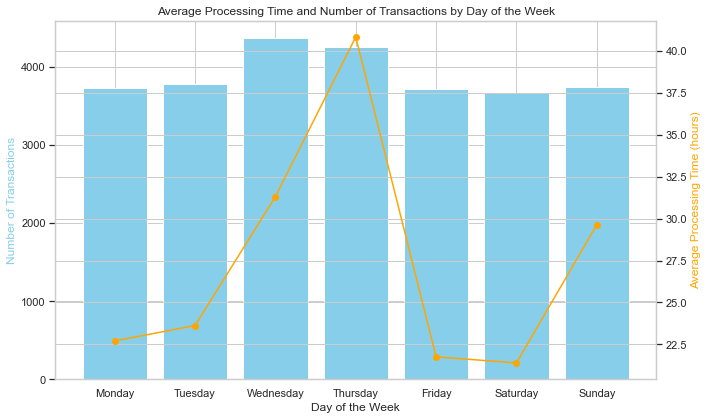

/var/folders/06/sg182g311t3g1k3tfn7v26jh0000gn/T/ipykernel_21796/3513709566.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_processing_times['yearmonth'] = df_processing_times['requested_at'].dt.to_period('M')


<Figure size 432x288 with 0 Axes>

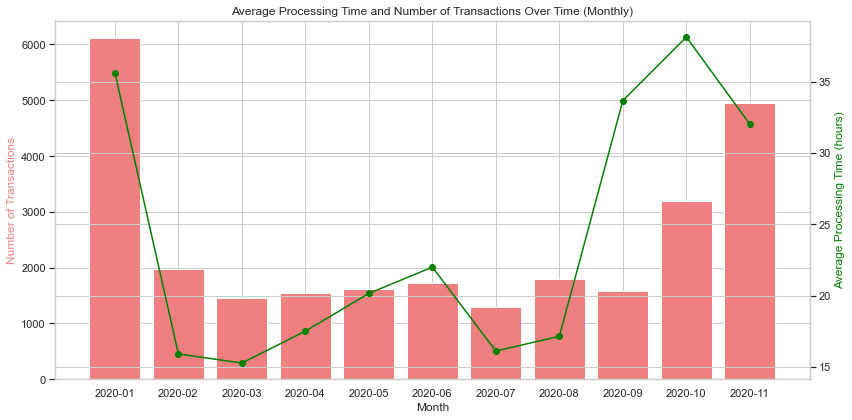

/var/folders/06/sg182g311t3g1k3tfn7v26jh0000gn/T/ipykernel_21796/3513709566.py:75: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_processing_times['hour_of_day'] = df_processing_times['requested_at'].dt.hour


<Figure size 432x288 with 0 Axes>

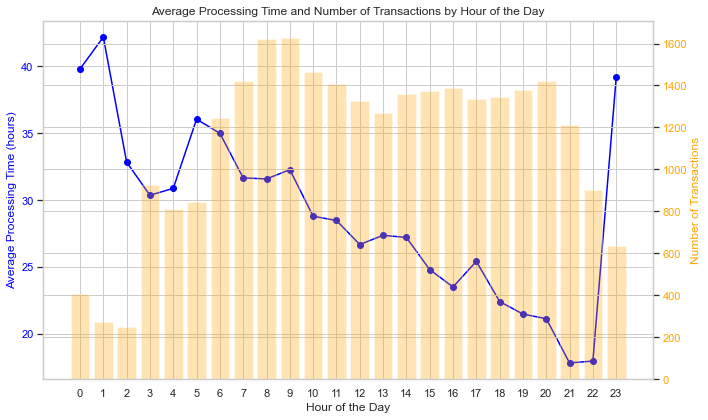

<Figure size 432x288 with 0 Axes>

In [286]:
# Group by day of the week and calculate mean processing time and count of transactions
daily_processing_time = df_processing_times.groupby('requested_day_of_week')['time_to_complete'].mean()
daily_transaction_count = df_processing_times.groupby('requested_day_of_week')['time_to_complete'].count()

# Sort days of the week in correct order
daily_processing_time = daily_processing_time[ordered_days]
daily_transaction_count = daily_transaction_count[ordered_days]

# Plot mean processing time and number of transactions by day of the week
fig, ax1 = plt.subplots(figsize=(10, 6))

# Bar plot for the number of transactions
ax1.bar(daily_processing_time.index, daily_transaction_count, color='skyblue', label='Number of Transactions')

# Set labels for the first axis (Number of Transactions)
ax1.set_xlabel('Day of the Week')
ax1.set_ylabel('Number of Transactions', color='skyblue')

# Create a second y-axis for processing time
ax2 = ax1.twinx()

# Line plot for average processing time
ax2.plot(daily_processing_time.index, daily_processing_time, color='orange', marker='o', label='Average Processing Time')

# Set labels for the second axis (Average Processing Time)
ax2.set_ylabel('Average Processing Time (hours)', color='orange')

# Set the title and tighten layout
plt.title('Average Processing Time and Number of Transactions by Day of the Week')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# Save plot to a file
plt.savefig('Outputs/Plots/daily_processing_time.png')

# =========================================================================================

# Time-based trends: Monthly trends in processing time and number of transactions
df_processing_times['yearmonth'] = df_processing_times['requested_at'].dt.to_period('M')
monthly_processing_time = df_processing_times.groupby('yearmonth')['time_to_complete'].mean()
monthly_transaction_count = df_processing_times.groupby('yearmonth')['time_to_complete'].count()

# Plot mean processing time and number of transactions by month
fig, ax1 = plt.subplots(figsize=(12, 6))

# Bar plot for the number of transactions
ax1.bar(monthly_processing_time.index.astype(str), monthly_transaction_count, color='lightcoral', label='Number of Transactions')

# Set labels for the first axis (Number of Transactions)
ax1.set_xlabel('Month')
ax1.set_ylabel('Number of Transactions', color='lightcoral')

# Create a second y-axis for processing time
ax2 = ax1.twinx()

# Line plot for average processing time
ax2.plot(monthly_processing_time.index.astype(str), monthly_processing_time, color='green', marker='o', label='Average Processing Time')

# Set labels for the second axis (Average Processing Time)
ax2.set_ylabel('Average Processing Time (hours)', color='green')

# Set the title and tighten layout
plt.title('Average Processing Time and Number of Transactions Over Time (Monthly)')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# Save plot to a file
plt.savefig('Outputs/Plots/monthly_processing_time.png')

# =========================================================================================

# Extract the hour from the requested_at time
df_processing_times['hour_of_day'] = df_processing_times['requested_at'].dt.hour

# Group by hour and calculate mean processing time
hourly_processing_time = df_processing_times.groupby('hour_of_day')['time_to_complete'].mean()

# Group by hour and count the number of transactions
hourly_transaction_count = df_processing_times.groupby('hour_of_day')['id'].count()

# Create a figure with two y-axes
fig, ax1 = plt.subplots(figsize=(10, 6))

# Plot the average processing time
ax1.plot(hourly_processing_time.index, hourly_processing_time.values, color='blue', marker='o', label='Average Processing Time')
ax1.set_xlabel('Hour of the Day')
ax1.set_ylabel('Average Processing Time (hours)', color='blue')
ax1.tick_params(axis='y', labelcolor='blue')

# Create a second y-axis for the number of transactions
ax2 = ax1.twinx()
ax2.bar(hourly_transaction_count.index, hourly_transaction_count.values, alpha=0.3, color='orange', label='Number of Transactions')
ax2.set_ylabel('Number of Transactions', color='orange')
ax2.tick_params(axis='y', labelcolor='orange')

# Set title and layout
plt.title('Average Processing Time and Number of Transactions by Hour of the Day')
plt.xticks(range(24))  # Display all hours
plt.tight_layout()

# Show the plot
plt.show()

# Save plot to a file
plt.savefig('Outputs/Plots/hourly_processing_time.png')



#### User analysis

In [287]:
# Print number of users and total amount withdrawn for each currency
currency_user_amount = df_processing_times.groupby('currency').agg(
    num_users=('user_id', 'nunique'),
    total_amount_native=('amount_native', 'sum')
)
print(currency_user_amount)

# Print total number of users
total_users = df_processing_times['user_id'].nunique()
print("\nTotal Number of Users:", total_users)


          num_users  total_amount_native
currency                                
AVAX           1211         48306.570664
BTC            2393         59524.948571
DOT             271          7061.598491
EUROC            89          4730.914606
MATIC           745         42891.769730
PEPE           3196        111768.723037
SHIB            692         64891.225035
SUSHI           616         17407.541576
UNI            2332        155769.142408
USDC            737         24571.411834
USDT            509         51043.525539
WECAN           489         17878.425398
XRP             525         54185.958630

Total Number of Users: 7716


In [288]:
# Calculate total number of withdrawals per user
user_withdrawals_count = df.groupby('user_id')['id'].count()

# Calculate total withdrawal amount per user in native currency
user_total_withdrawals = df.groupby('user_id')['amount_native'].sum()

# Calculate total withdrawal amount per user in USD
user_total_withdrawals_usd = df.groupby('user_id')['amount_usd'].sum()

# Calculate average withdrawal amount per user in native currency
user_avg_withdrawals = df.groupby('user_id')['amount_native'].mean()

# Calculate number of different currencies used by each user
user_num_different_currencies = df.groupby('user_id')['currency'].nunique()

# Calculate the most traded currency for each user (the mode of the currency)
user_most_traded_currency = df.groupby('user_id')['currency'].apply(lambda x: x.mode()[0])

# Calculate average processing time per user (excluding negative processing times)
df_processing_times = df[df['possible_error'] == False]  # Exclude negative processing times
user_avg_processing_time = df_processing_times.groupby('user_id')['time_to_complete'].mean()

# Calculate maximum withdrawal amount in USD per user
user_max_withdrawal_usd = df.groupby('user_id')['amount_usd'].max()

# Combine the metrics into one DataFrame
user_summary = pd.DataFrame({
    'withdrawals_count': user_withdrawals_count,
    'total_withdrawals': user_total_withdrawals,
    'total_withdrawals_usd': user_total_withdrawals_usd,
    'avg_withdrawal_size': user_avg_withdrawals,
    'num_different_currencies': user_num_different_currencies,
    'most_traded_currency': user_most_traded_currency,
    'avg_processing_time': user_avg_processing_time,
    'max_withdrawal_usd': user_max_withdrawal_usd
})


# Show the table in a more user-friendly format
display(user_summary)





,withdrawals_count,total_withdrawals,total_withdrawals_usd,avg_withdrawal_size,num_different_currencies,most_traded_currency,avg_processing_time,max_withdrawal_usd
user_id,,,,,,,,
42568388,1,17.457718,67618.413400,17.457718,1,PEPE,28.001389,67618.413400
42569705,6,104.680158,3300.073444,17.446693,1,BTC,31.972037,587.224653
42569816,1,17.488438,1216.189882,17.488438,1,WECAN,12.708611,1216.189882
42569944,3,52.340541,4492.614874,17.446847,1,PEPE,10.979167,2026.778578
42570216,1,17.447191,2839.108581,17.447191,1,PEPE,12.932778,2839.108581
...,...,...,...,...,...,...,...,...
47947360,1,17.446664,547.630192,17.446664,1,BTC,44.344444,547.630192
47948220,1,17.447010,2864.004904,17.447010,1,PEPE,26.806111,2864.004904
47959410,4,69.787138,2181.831699,17.446784,3,PEPE,25.222222,547.129633


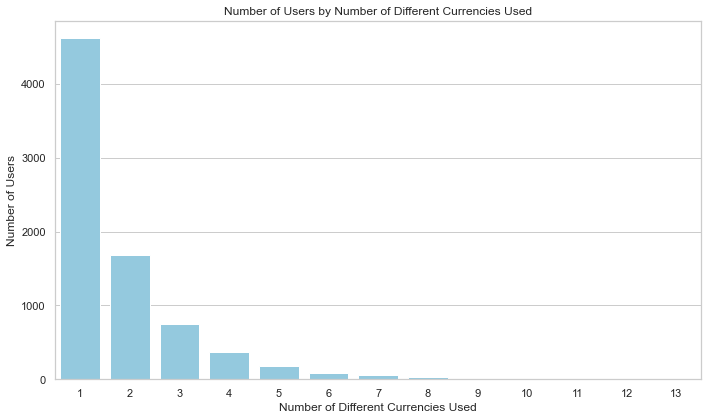

<Figure size 432x288 with 0 Axes>

In [289]:
# Count how many users have used each number of different currencies
user_currency_count = user_summary['num_different_currencies'].value_counts().sort_index()

# Create a bar plot to show the number of users for each num_different_currencies
plt.figure(figsize=(10, 6))
sns.barplot(x=user_currency_count.index, y=user_currency_count.values, color='skyblue')

# Set the title and labels
plt.title('Number of Users by Number of Different Currencies Used')
plt.xlabel('Number of Different Currencies Used')
plt.ylabel('Number of Users')

# Show the plot
plt.tight_layout()
plt.show()

# Save plot to a file
plt.savefig('Outputs/Plots/users_by_currency_count.png')

In [290]:
# Define the trade frequency categories based on the number of withdrawals
def categorize_trader(trade_count):
    if trade_count <= 5:
        return 'Low Frequency User (0-5)'
    elif trade_count <= 20:
        return 'Medium Frequency User (6-20)'
    else:
        return 'High Frequency User (21+)'

# Apply the categorization function to the withdrawals count
user_summary['trade_frequency_category'] = user_summary['withdrawals_count'].apply(categorize_trader)

# Group by trade frequency category and calculate the requested statistics
trade_category_stats = user_summary.groupby('trade_frequency_category').agg(
    num_users=('withdrawals_count', 'size'),  # Count the number of users in each category
    mean_amount=('total_withdrawals_usd', 'mean'),   # Mean of total_withdrawals_usd
    median_amount=('total_withdrawals_usd', 'median'),  # Median of total_withdrawals_usd
    max_amount=('total_withdrawals_usd', 'max'),     # Max of total_withdrawals_usd
    min_amount=('total_withdrawals_usd', 'min'),     # Min of total_withdrawals_usdy
    avg_processing_time=('avg_processing_time', 'mean'),  # Mean of avg_processing_time
    avg_number_of_currencies=('num_different_currencies', 'mean'),  # Mean of num_different_currencies
    avg_number_of_withdrawals=('withdrawals_count', 'mean'),  # Mean of withdrawals_count
    most_traded_currency=('most_traded_currency', lambda x: x.value_counts().index[0])  # Most frequent currency
).reset_index()

# Show the statistics table
display(trade_category_stats)





,trade_frequency_category,num_users,mean_amount,median_amount,max_amount,min_amount,avg_processing_time,avg_number_of_currencies,avg_number_of_withdrawals,most_traded_currency
0,High Frequency User (21+),62,123230.327261,22938.150838,4.204712e+06,11463.552705,24.850723,5.661290,123.596774,PEPE
1,Low Frequency User (0-5),6959,4786.811894,1284.103826,7.605366e+05,536.000098,31.282786,1.503521,1.874407,PEPE
2,Medium Frequency User (6-20),779,21562.476169,7359.433047,7.856245e+05,3263.718331,28.399719,4.048780,8.942234,PEPE


trade_frequency_category
High Frequency User (21+)       24.850723
Low Frequency User (0-5)        31.282786
Medium Frequency User (6-20)    28.399719
Name: avg_processing_time, dtype: float64

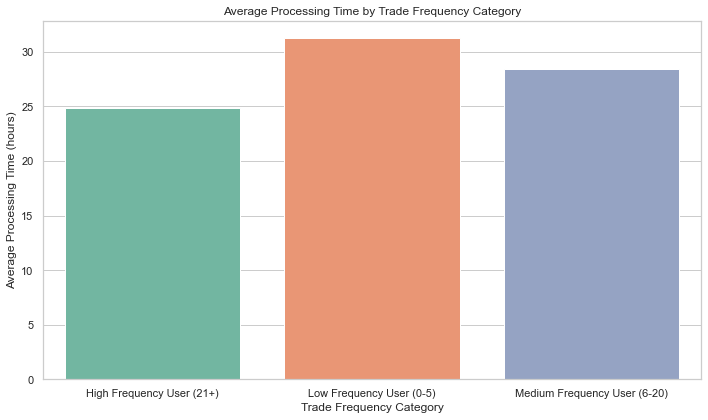

<Figure size 432x288 with 0 Axes>

In [291]:
# Compare average processing time for each category
processing_time_comparison = user_summary.groupby('trade_frequency_category')['avg_processing_time'].mean()
display(processing_time_comparison)

# Plot processing time by trade frequency category
plt.figure(figsize=(10, 6))
sns.barplot(x=processing_time_comparison.index, y=processing_time_comparison.values, palette='Set2')
plt.title('Average Processing Time by Trade Frequency Category')
plt.xlabel('Trade Frequency Category')
plt.ylabel('Average Processing Time (hours)')
plt.tight_layout()
plt.show()

# Save plot to a file
plt.savefig('Outputs/Plots/processing_time_by_trade_frequency.png')



In [292]:
# Calculate the conversion rate for each user and currency
df['conversion_rate'] = df['amount_usd'] / df['amount_native']

# Add the trade frequency category to the dataframe
df = df.merge(user_summary[['trade_frequency_category']], on='user_id', how='left')

# Group by trade frequency category and currency, and calculate the mean conversion rate for each group
conversion_rate_comparison = df.groupby(['trade_frequency_category', 'currency'])['conversion_rate'].mean().reset_index()


display(conversion_rate_comparison)



,trade_frequency_category,currency,conversion_rate
0,High Frequency User (21+),AVAX,48.772822
1,High Frequency User (21+),BTC,99.183383
2,High Frequency User (21+),DOT,32.400450
3,High Frequency User (21+),EUROC,34.404547
4,High Frequency User (21+),MATIC,38.105957
5,High Frequency User (21+),PEPE,124.592594
6,High Frequency User (21+),SHIB,32.644916
7,High Frequency User (21+),SUSHI,34.345198
8,High Frequency User (21+),UNI,31.483144
9,High Frequency User (21+),USDC,35.798591


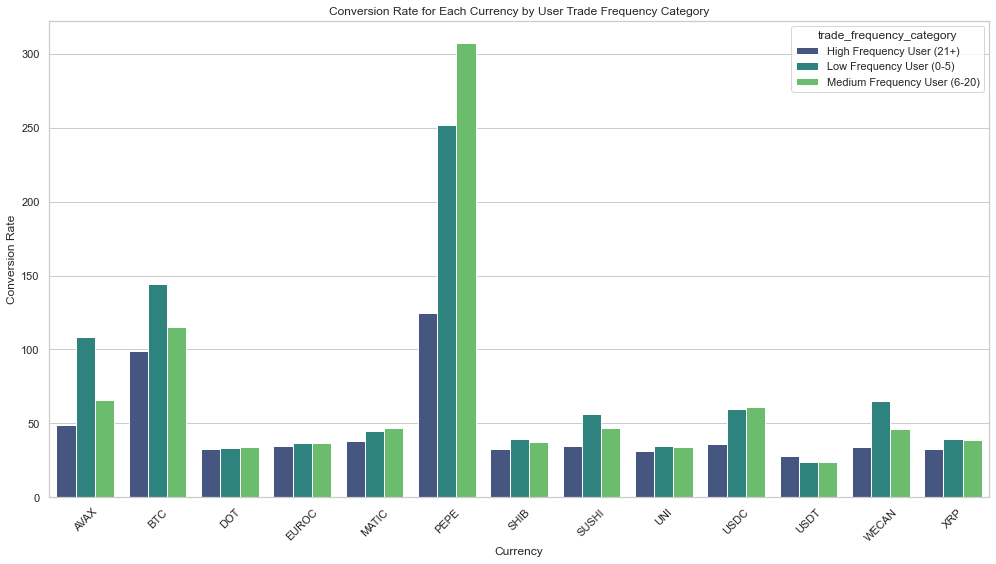

<Figure size 432x288 with 0 Axes>

In [293]:

# Plotting conversion rate for each currency and trade frequency category
plt.figure(figsize=(14, 8))

# Create a bar plot where 'trade_frequency_category' will be on the x-axis, 'conversion_rate' on the y-axis
sns.barplot(x='currency', y='conversion_rate', hue='trade_frequency_category', data=conversion_rate_comparison, palette='viridis')

# Set plot title and labels
plt.title('Conversion Rate for Each Currency by User Trade Frequency Category')
plt.xlabel('Currency')
plt.ylabel('Conversion Rate')

# Rotate x-axis labels for readability
plt.xticks(rotation=45)

# Display the plot
plt.tight_layout()
plt.show()

# Save plot to a file
plt.savefig('Outputs/Plots/conversion_rate_by_trade_frequency.png')



In [294]:
# Find the row with the maximum conversion rate for each currency
best_conversion_rate = conversion_rate_comparison.loc[conversion_rate_comparison.groupby('currency')['conversion_rate'].idxmax()]

# Display the best conversion rate for each currency and the corresponding user category
display(best_conversion_rate)


,trade_frequency_category,currency,conversion_rate
13,Low Frequency User (0-5),AVAX,108.297085
14,Low Frequency User (0-5),BTC,144.021254
28,Medium Frequency User (6-20),DOT,34.279807
16,Low Frequency User (0-5),EUROC,36.735412
30,Medium Frequency User (6-20),MATIC,46.825198
31,Medium Frequency User (6-20),PEPE,307.109007
19,Low Frequency User (0-5),SHIB,39.204656
20,Low Frequency User (0-5),SUSHI,56.164018
21,Low Frequency User (0-5),UNI,34.505046
35,Medium Frequency User (6-20),USDC,61.086651


### Data Summary and Key Findings

We have now analysed the data by four main categories:
- Conversion rate
- Withdrawal size
- Processing time
- User behaviour

##### Conversion rate
We have 13 different currencies that have vastly different volatility. PEPE and BTC have by far the highest volatilities. There are some more stable currnecies, most stable seems to be DOT which has the lowest absolute and relative standard diviation. On average the volatility of the entire market is very high.

Another peculiar attribute is the the minimal conversion rates of almost every currency is 30.722. However, this is likely just a feature that comes out of the way data was generated.

When we present the more volatile currencies as a time series we see there are many anomalies, where the price of the asset jumps by up to 800,000% for one withdrawal and then drops right back down. This could be a serious issue, since te actual currency value is likely not reflecting this jump. Meaning, **there could be an issue in the lending system that allows for withdrawals at the wrong USD price.** This phenomenon apears, although less frequently among some lower volatility currencies as well.

We have also looked at the volatiliy of conversion rates based on the number of transactions for each currency. We notice that currencies with higher trading volume (volume of withdrawals) have higher volatility. 

##### Withdrawal size

The first thing we notice when we look at size of withdrawals is that we have a lower bound at 17.446609 units of currency for all assets. This likely means there is a set boundry that limits the smallest possible withdrawal. Since mean and median are also very close to that value (additionally median is lower than the mean), we can say the **majority of withdrawals is done at or near the lower limit**. This can also be seen in the graph showing the distribution of USDT withdrawals, which is the currency with the highest mean withdrawal and highest standard diviation.

We then looked at the correlation between the withdrawal size and conversion rate. Here we can see that for most less volatile assets the scatterplots look as you would expect. A lot of lower quantity withdrawals spread evenly throughout all different conversion rates, with bigger withdrawals comming with higher conversion rates (clients with bigger positions realising their earnings). 

A bigger surprise comes with the more volatile assets like BTC and PEPE (To some extent we can also see this in AVAX and DOT). There we have a almost linear correlation between amount_native withdrawn and the conversion rate. Meaning, **if ther is an actual issue with some withdrawals processing with vastly higher conversion rates, users can see it and exploit it, by dumping bigger amounts of their currencies at the boosted conversion rates.**

##### Processing Time

Looking at different processing times we can see that over $\frac23$ requests get processed within the first day and over 85% of transactions are done within the first two days.

Processing times differ for different currencies. We can see that currencies with higher trade volume have higher processing times.

Looking at correlation between processing time and the size of the withdrawal we can see there is very little corelation (in native currency or USD). This probably means there is no priority based on size.

Now we will look at the processing time based on the withdrawal request day or month. Interestingly even though **number of transactions are fairly similar for all days of the week with small increases on Wednesday and Thursday, there is an around 80% increase in processing times**. There is another (smaller) increase on Sundays. We can assume that stems from a lower amount of working staff. Withdrawal times also increase in the months leading up to new year, the slowest processing times spanning from September to January. There is also an increase in number of transactions in those months, which explains the slower processing times.

When analysing processing times based on time of request we see that withdrawal requests issued between 11PM and 2AM have drastically higher processing times. There is a more than 20 hour increase in processing comparing requests submitted at 22PM and 23PM. **This could indicate that late night requests get lost in the system**.

##### User Behaviour 

From the data we see that currencies with the highest number of users are PEPE, BTC, UNI and AVAX. UNI and PEPE also have the highest amount of currency withdrawn. **Most of the users only lend one currency and the number of users for each additional currency decreases exponentially**.

We can divide users into three categories:
- High frequency (over 20 transactions)
- Medium frequency (between 6 and 20 transactions)
- Low frequency (5 or less transactions)

Most of the users are low frequency. Most of these users trade rarely and at low volumes. Unexpectedly there are very few low frequency high volume users. The highest volume withdrawals fall among the high frequency users. We can assume some of these users are using algorithms that withdraw the funds whenever there is a mispricing that we discovered in the first two parts.

Processing times are the fastest for high frequency users and they are the slowest for low frequency users. This probably means the process of withdrawal is streamlined for users who frequently withdraw funds.

Interestingly, in contradiction to previous findings the best conversion rates, mostly for the high volatility assets are given to low and medium frequency users. This means the low frequency users only withdraw funds when there are big capital gains to be realised.








### Improvement opportunities and recommendations

1. Address Date logging errors:

**Issue**: We observe many date logging errors for requested_at and finished_at. These errors span from invalid dates logged to negative differences between requested_at and finished_at datetimes.

**Improvement**: **Implement Date Validation**. When dates are logged, ensure they are valid and fall within acceptable ranges (e.g., not invalid dates). **Automate Date Cleaning**. During data ingestion or processing, automatically convert any invalid date entries to NaT (Not a Time), and flag these rows for review.  If an invalid date cannot be automatically corrected, a **predefined fallback date** could be used, or the transaction should be **marked for manual review**.

2. Address Conversion Rate Anomalies:

**Issue**: We've observed significant spikes in conversion rates for certain currencies, particularly PEPE and BTC. These spikes can reach up to 800,000% for individual withdrawals and then drop right back down. This could be a serious issue in the lending system, as the price at the time of withdrawal might not reflect the actual currency value.

**Improvement**: To improve the system's reliability and prevent exploitation of mispricing, a **review of the conversion rate logic** is needed. Ensure that the conversion rates are recalculated correctly and consistently for every withdrawal. Adding **real-time validation checks** against the current market value could help mitigate these sudden fluctuations. If conversion rates deviate from expected market prices, the system could **flag the transaction** for manual review or automatically halt withdrawals until the issue is resolved.

3. Withdrawal Lower Limit Issue:

**Issue**: The data indicates that most withdrawals are **near the lower boundary** of the withdrawal size limit (**17.446609 units**). This indicates a **lack of flexibility** or options for smaller withdrawals.

**Improvement**: **Expand the withdrawal size limit**s or allow for **tiered withdrawal sizes** to accommodate a wider range of users. This could improve the user experience for those who wish to withdraw smaller amounts. Additionally, allowing for custom withdrawal size limits could increase user participation in the lending program bringing in higher profits for the company.

4. Reduce Volatility in High-Volume Currencies:

**Issue**: Currencies with higher trading volume (like BTC and PEPE) exhibit significantly higher volatility in their conversion rates.

**Improvement**: Implement more sophisticated **slippage controls or dynamic pricing** that smooths out conversion rate volatility during high-volume periods. This would improve reliability and ensure that users get consistent conversion rates without unexpected spikes. Also, **introducing buffers for large withdrawals** could prevent massive fluctuations caused by large transactions.

5. Improve Processing Time During Peak Hours:

**Issue**: **Processing times are significantly higher during certain periods** of the day (especially late-night hours between 11 PM and 2 AM), as well as during high-traffic months leading up to the New Year.

**Improvement**: **Optimize resource allocation** for late-night hours or low-staff periods. Consider implementing **automated systems** to handle withdrawals during these times, or **shift resources to high-traffic hours** to minimize delays. Additionally, improving load balancing and scaling infrastructure during high-traffic months could significantly reduce processing delays.

6. Fix System Delays Caused by Late-Night Requests

**Issue**:  **Late-night withdrawal requests show drastic increases in processing times**, potentially due to system bottlenecks or a lack of staff at night.

**Improvement**: **Automate late-night withdrawal processing** using algorithms that can handle routine requests, or increase staff during late-night shifts to handle these requests more efficiently. Alternatively, **introducing queue management systems** could help prioritize requests based on urgency.

